In [1]:
class my_TSNE():
    def __init__(self, n_components=2, perplexity=25.0, learning_rate=100, n_iter=1000, alpha=0):
        self.perplexity = perplexity # entre 5 et 50
        self.learning_rate = learning_rate
        self.dim = n_components
        self.n_iter = n_iter
        self.alpha = alpha

    def fit_transform(self,x):
        self.x = x
        n,m = self.x.shape

        # Recherche dichotomique du sigma (entre le max des distances et le min)
        
        # Utiliser la décomposition matriciel pour calculer la norm ||xi-xj||² = <xi-xj; xi-xj> 
        x_norm = np.sum(self.x**2,axis=1).reshape(1, n)
        distancex = x_norm + x_norm.T - 2 * np.dot(self.x,self.x.T)
        
        inf = np.zeros((n,1))
        sup = np.ones((n,1)) * np.max(distancex)
        self.sigma = (inf+sup)/2.0
        
        self.lperp = np.log2(self.perplexity)
    
        while True:
            #calcul de p(j|i) (cf equation 1)
            self.pcond = np.exp( -distancex /(2.0*self.sigma**2) )
            self.pcond /= (( self.pcond-np.eye(n) ).sum(axis=1) ).reshape( n,1 ) # ne pas compter si k=i,n

            #calcul de l'entropie
            self.entr = - np.sum(  self.pcond * np.log2(self.pcond), axis=0 )
            
            #calcul de perplexity
            self.perplexity = 2**self.entr
            
            for i in xrange(n):
                if ( self.perplexity[i] < self.lperp ):
                    inf[i] = self.sigma[i]
                else:
                    sup[i] = self.sigma[i]
            sigma_old = self.sigma
            self.sigma = ((sup + inf) / 2.)
            if np.max(np.abs(sigma_old - self.sigma)) < 1e-5:
                break

        
        self.pij = (self.pcond+self.pcond.T) / (2.0*n)
        np.fill_diagonal(self.pij, 0)
        
        # init y
        self.y = np.zeros( (self.n_iter+2,n,self.dim) )
        self.y[1] =  np.random.normal(0, 1e-4, (n, self.dim))#1

        loss = []
        #gradient descent
        for t in xrange( 1, self.n_iter + 1 ):
            # calcul de qij
            y_norm = np.sum(self.y[t]**2,axis=1).reshape(1, n)
            distance_y = y_norm + y_norm.T - 2 * np.dot(self.y[t],self.y[t].T)
            
            self.qij = 1 / ( 1 + distance_y )
            np.fill_diagonal(self.qij, 0)
            self.qij = self.qij/self.qij.sum()

            yt = self.y[t]
            grad = 4 * ( (self.pij-self.qij) / (1 + distance_y)).reshape(n,n,1)
            for i in range(n):
                grad_i = ( grad[i] * (yt[i] - yt) ).sum(0)
                self.y[t+1][i] = yt[i] - self.learning_rate * grad_i + self.alpha * (yt[i] - self.y[t-1][i])            
            
            l = stats.entropy(self.pij, self.qij, 2).mean()
            loss.append(l)
            if (t % 1 == 30):
                print t,l, self.pij.mean(), self.qij.mean(), yt.mean()
        return self.y[-1,:,:]

In [2]:
def plot_embedding_2D(X,y):
    fig = plt.figure()
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.show()
    
def plot_embedding_3D(X,y):
    fig = plt.figure()
    ax=Axes3D(fig)
    ax.scatter(X[:,0], X[:,1],X[:,2],c=y)
    plt.show()

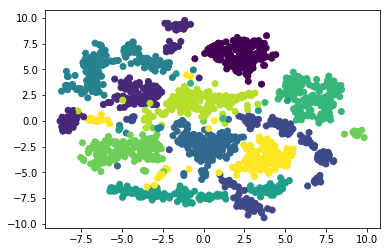

In [3]:
from sklearn import manifold
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn import datasets

data = datasets.load_digits()

X_new = my_TSNE(n_components=2, perplexity=30.0, learning_rate=1000.0, n_iter=50, alpha=0).fit_transform(data.data)
plot_embedding_2D(X_new, data.target)

In [12]:
X_new = my_TSNE(n_components=2, perplexity=30.0, learning_rate=1000.0, n_iter=50, alpha=0).fit_transform(X)

c:\python27\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log2
c:\python27\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply
c:\python27\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in power


Populating the interactive namespace from numpy and matplotlib


c:\python27\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log2
c:\python27\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply
c:\python27\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in power


Text(0.5,1,u'Apres 50 iterations')

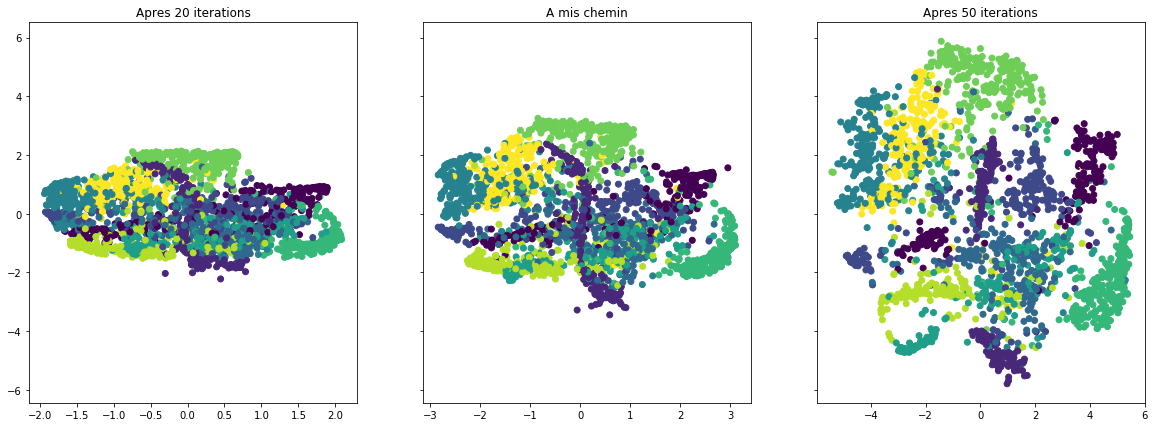

In [25]:
from sklearn.datasets import load_digits
%pylab inline
# data = load_digits()

X_new = my_TSNE(n_components=2, perplexity=30.0, learning_rate=1000.0, n_iter=50, alpha=0).fit_transform(X)

plt.figure()
f, axarr = plt.subplots(1, 3,figsize=(20, 7), sharey=True)

x_new = np.array(X_new[20])
axarr[0].scatter(x_new[:, 0], x_new[:, 1], c=labels)
axarr[0].set_title('Apres 20 iterations')

x_new = np.array(X_new[len(X_new) / 2])
axarr[1].scatter(x_new[:, 0], x_new[:, 1], c=labels)
axarr[1].set_title('A mis chemin')

x_new = np.array(X_new[-1])
axarr[2].scatter(x_new[:, 0], x_new[:, 1], c=labels)
axarr[2].set_title('Apres ' + str(len(X_new) - 2) + ' iterations')